# This is standard issue autoencoder for image compression

26422272it [00:03, 7179861.36it/s]                              
Extracting /home/danieldroder/data/fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/danieldroder/data/fashion_mnist/FashionMNIST/raw
29696it [00:00, 251675.70it/s]                           
Extracting /home/danieldroder/data/fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/danieldroder/data/fashion_mnist/FashionMNIST/raw
4422656it [00:01, 3974642.75it/s]                             
Extracting /home/danieldroder/data/fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/danieldroder/data/fashion_mnist/FashionMNIST/raw
6144it [00:00, 16854024.71it/s]         
/hdd_storage/anaconda/envs/pytorchGpu/lib/python3.7/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to

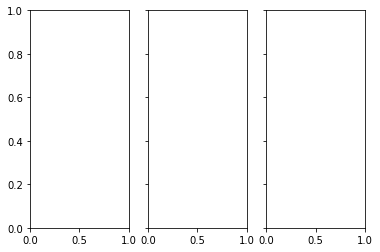

In [2]:
%matplotlib inline
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
import torch.nn as nn
import os
from os import listdir
import tensorflow as tf
import torch
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import imutils  
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import pickle
from keras.models import Sequential
import numpy as np 
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from PIL import Image
from keras.datasets import mnist
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch import utils

#python files
from UTILS.class_dict import dictionary
from loadImDat import scaleTo01,loadData

class AE(nn.Module):
    #this class will create an autoencoding object
    #the objective is to simply create the autoencoder object
    #and then pass in training data to train the model
    #to very simply create the autoencoder
    def __init__(self, **kwargs):
        super().__init__()
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/modelFashion.pt"
        self.encoder=nn.Sequential(torch.load(model_dir)
        )
        self.encoder.eval()
        self.encoder2=nn.Sequential(
            nn.Linear(in_features=784,out_features=484)
            )
        self.encoder2.eval()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=484, out_features=550),
            nn.ReLU(),
            nn.Linear(in_features=550, out_features=650),
            nn.ReLU(),
            nn.Linear(in_features=650, out_features=725),
            nn.ReLU(),
            nn.Linear(in_features=725, out_features=784),
            nn.Sigmoid()
        )
    def trainAE(self,epochs,train_data,save=False,decoderName=1,writeTb=True):
        """
        this is a method that will train the autoencoder.
        After this runs, it will update the constructed AE (auto encoder)
        to be a trained model.
        """
        for epoch in range(epochs):
            loss = 0
            for batch_features, _ in train_data:
                batch_features = batch_features.view(-1, 784).to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                
                train_loss = criterion(outputs, batch_features)
                
                train_loss.backward()
                
                optimizer.step()
                
                loss += train_loss.item()
            
                

            loss = loss / len(train_data)
            if writeTb:
                tb.add_scalar("Loss",loss,epoch)
                tb.close()
            
            print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        if save:
            self.saveModel(modelName=decoderName)
    def forward(self, features):
        """
        this method is the logic for the forward prop. of the model.
        """
        x=self.encoder(features)
        x=self.encoder2(x)
        x=self.decoder(x)
        return x
    def getEncoderImage(self,x):
        """
        this method will pass an image through the encoder
        and returns that image. This is mostly just for
        adding the image to the tensorboard display.
        """
        encoded_image=self.encoder(x)
        encoded_image=self.encoder2(encoded_image)
        return encoded_image
    def saveModel(self,modelName=1):
        """
        this method will contain the code for saving the decoder model
        """
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt"
        torch.save(self.decoder,model_dir)
        print(f"model saved to {model_dir}")




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tb=SummaryWriter()
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


trainload,testload=loadData("fashion_mnist",28,10)
images,labels=next(iter(trainload))
grid=torchvision.utils.make_grid(images)
images=images.to('cuda:0')
tb.add_graph(model,images)
model.trainAE(epochs=20,train_data=trainload,save=True)
train_data=[]
for batch_idx, (true_sigs, im_labels) in enumerate(testload):
    train_data.append(true_sigs)

im_test=train_data[5][0]
im_test2=im_test.reshape(28,28)
im_test2=im_test.to('cuda:0')
pred=model(im_test2)
pred1=pred.cpu().data.numpy()
pred1=pred1.reshape(28,28)
pred=pred.cpu().reshape(28,28)
img_grid=torchvision.utils.make_grid(pred)
tb.add_image("Prediction",img_grid)

fig,axs=plt.subplots(1,3,sharey='row')
im_test2=im_test2.reshape(28,28)
im_test=im_test.to('cuda:0')
encoded_img=model.getEncoderImage(x=im_test)
encoded_img_tb=encoded_img.cpu().reshape(22,22)
img_grid=torchvision.utils.make_grid(encoded_img_tb)
tb.add_image("Encoded",img_grid)
encoded_img=encoded_img.cpu().data.numpy()
encoded_img=encoded_img.reshape(22,22)
im_test2=im_test2.cpu()
im_test3=im_test2.reshape(28,28)
img_grid=torchvision.utils.make_grid(im_test3)
tb.add_image("Original",img_grid)
tb.close()








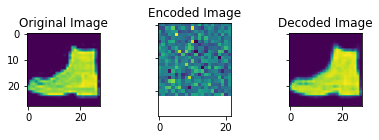

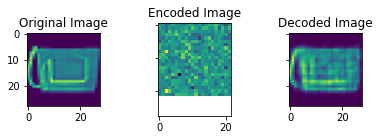

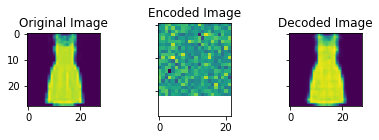

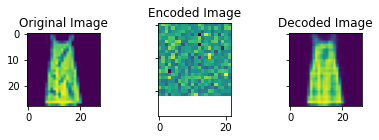

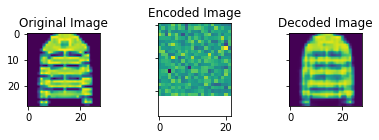

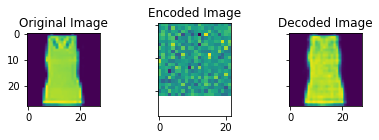

In [6]:
%matplotlib inline
def plot_images(original_image,model):
    fig,axs=plt.subplots(1,3,sharey='row')
    original_image=original_image.to("cuda:0")
    axs[0].set_title("Original Image")
    axs[0].imshow(original_image.cpu().reshape(28,28))
    # print(f"shape of og_img:{im_test2.shape}")
    encoded_img=model.getEncoderImage(original_image)
    encoded_img=encoded_img.cpu().reshape(22,22)
    # print(encoded_img.shape)
    axs[1].set_title("Encoded Image")

    axs[1].imshow(encoded_img.detach().numpy())
    # print(f"shape of encoded_img:{encoded_img.shape}")
    axs[2].set_title("Decoded Image")
    pred_img=model(original_image)
    pred_img=pred_img.cpu().reshape(28,28)
    axs[2].imshow(pred_img.detach().numpy())
    # print(f"shape of decoded_img:{pred1.shape}")
    plt.subplots_adjust(wspace=.8)
    plt.show()
    # return axs
# test1=train_data[802][0]
# test2=test1.to("cuda:0")
# pred=model(test2)
# axs[0].set_title("Hi")
# axs[0].imshow(pred.cpu().detach().numpy().reshape(28,28))
# axs[1].imshow(test1.cpu().detach().numpy().reshape(28,28))
plot_images(train_data[802][0],model=model)
plot_images(train_data[22][0],model=model)
plot_images(train_data[33][0],model=model)
plot_images(train_data[45][0],model=model)
plot_images(train_data[51][0],model=model)
plot_images(train_data[805][0],model=model)

# This takes in the entire encoding space and reconstructs the image from the FISTA sparse encoded image

epoch : 1/13, loss = 0.023508
epoch : 2/13, loss = 0.012613
epoch : 3/13, loss = 0.009893
epoch : 4/13, loss = 0.008415
epoch : 5/13, loss = 0.007396
epoch : 6/13, loss = 0.006654
epoch : 7/13, loss = 0.006087
epoch : 8/13, loss = 0.005620
epoch : 9/13, loss = 0.005234
epoch : 10/13, loss = 0.004910
epoch : 11/13, loss = 0.004634
epoch : 12/13, loss = 0.004391
epoch : 13/13, loss = 0.004173
model saved to /nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt


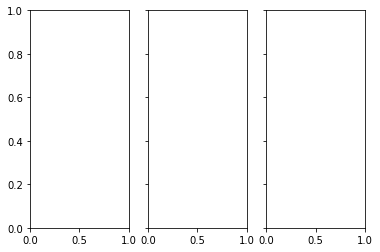

In [3]:
%matplotlib inline
import os 
import glob
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import mnist
from torch.autograd import Variable
from torch import Tensor
import cv2
import torch.nn.functional as F
from loadImDat import loadData
from UTILS.class_dict import dictionary
import torchvision
from keras.datasets import mnist
from loadImDat import scaleTo01
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


class AE(nn.Module):
    #this class will create an autoencoding object
    #the objective is to simply create the autoencoder object
    #and then pass in training data to train the model
    #to very simply create the autoencoder
    def __init__(self, **kwargs):
        super().__init__()
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/modelFashion.pt"
        self.encoder=nn.Sequential(torch.load(model_dir)
        )
        self.encoder.eval()
        # self.encoder2=nn.Sequential(
            # nn.Linear(in_features=784,out_features=484)
            # )
        # self.encoder2.eval()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=784),
            nn.ReLU(),
            nn.Linear(in_features=784, out_features=784),
            nn.ReLU(),
            nn.Linear(in_features=784, out_features=784),
            nn.ReLU(),
            nn.Linear(in_features=784, out_features=784),
            nn.Sigmoid()
        )
    def trainAE(self,epochs,train_data,save=False,decoderName=1,writeTb=True):
        """
        this is a method that will train the autoencoder.
        After this runs, it will update the constructed AE (auto encoder)
        to be a trained model.
        """
        for epoch in range(epochs):
            loss = 0
            for batch_features, _ in train_data:
                batch_features = batch_features.view(-1, 784).to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                
                train_loss = criterion(outputs, batch_features)
                
                train_loss.backward()
                
                optimizer.step()
                
                loss += train_loss.item()
            
                

            loss = loss / len(train_data)
            if writeTb:
                tb.add_scalar("Loss",loss,epoch)
                tb.close()
            
            print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        if save:
            self.saveModel(modelName=decoderName)
    def forward(self, features):
        """
        this method is the logic for the forward prop. of the model.
        """
        x=self.encoder(features)
        # x=self.encoder2(x)
        x=self.decoder(x)
        return x
    def getEncoderImage(self,x):
        """
        this method will pass an image through the encoder
        and returns that image. This is mostly just for
        adding the image to the tensorboard display.
        """
        encoded_image=self.encoder(x)
        # encoded_image=self.encoder2(encoded_image)
        return encoded_image
    def saveModel(self,modelName=1):
        """
        this method will contain the code for saving the decoder model
        """
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt"
        torch.save(self.decoder,model_dir)
        print(f"model saved to {model_dir}")




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tb=SummaryWriter()
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


trainload,testload=loadData("fashion_mnist",28,10)
images,labels=next(iter(trainload))
grid=torchvision.utils.make_grid(images)
images=images.to('cuda:0')
tb.add_graph(model,images)
model.trainAE(epochs=13,train_data=trainload,save=True)
train_data=[]
for batch_idx, (true_sigs, im_labels) in enumerate(testload):
    train_data.append(true_sigs)

im_test=train_data[5][0]
im_test2=im_test.reshape(28,28)
im_test2=im_test.to('cuda:0')
pred=model(im_test2)
pred1=pred.cpu().data.numpy()
pred1=pred1.reshape(28,28)
pred=pred.cpu().reshape(28,28)
img_grid=torchvision.utils.make_grid(pred)
tb.add_image("Prediction",img_grid)

fig,axs=plt.subplots(1,3,sharey='row')
im_test2=im_test2.reshape(28,28)
im_test=im_test.to('cuda:0')
encoded_img=model.getEncoderImage(x=im_test)
encoded_img_tb=encoded_img.cpu().reshape(28,28)
img_grid=torchvision.utils.make_grid(encoded_img_tb)
tb.add_image("Encoded",img_grid)
encoded_img=encoded_img.cpu().data.numpy()
encoded_img=encoded_img.reshape(28,28)
im_test2=im_test2.cpu()
im_test3=im_test2.reshape(28,28)
img_grid=torchvision.utils.make_grid(im_test3)
tb.add_image("Original",img_grid)
tb.close()

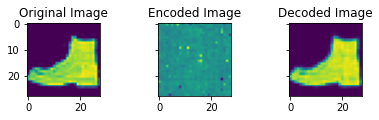

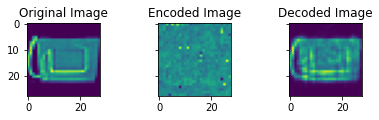

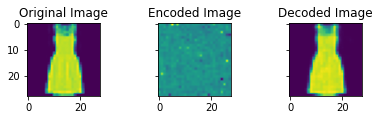

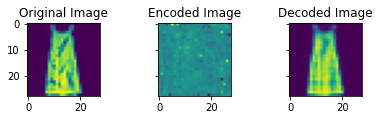

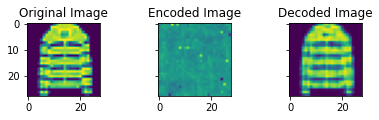

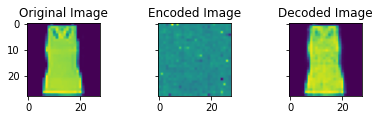

In [4]:
%matplotlib inline
def plot_images(original_image,model):
    fig,axs=plt.subplots(1,3,sharey='row')
    original_image=original_image.to("cuda:0")
    axs[0].set_title("Original Image")
    axs[0].imshow(original_image.cpu().reshape(28,28))
    # print(f"shape of og_img:{im_test2.shape}")
    encoded_img=model.getEncoderImage(original_image)
    encoded_img=encoded_img.cpu().reshape(28,28)
    # print(encoded_img.shape)
    axs[1].set_title("Encoded Image")

    axs[1].imshow(encoded_img.detach().numpy())
    # print(f"shape of encoded_img:{encoded_img.shape}")
    axs[2].set_title("Decoded Image")
    pred_img=model(original_image)
    pred_img=pred_img.cpu().reshape(28,28)
    axs[2].imshow(pred_img.detach().numpy())
    # print(f"shape of decoded_img:{pred1.shape}")
    plt.subplots_adjust(wspace=.8)
    plt.show()
    # return axs
# test1=train_data[802][0]
# test2=test1.to("cuda:0")
# pred=model(test2)
# axs[0].set_title("Hi")
# axs[0].imshow(pred.cpu().detach().numpy().reshape(28,28))
# axs[1].imshow(test1.cpu().detach().numpy().reshape(28,28))
plot_images(train_data[802][0],model=model)
plot_images(train_data[22][0],model=model)
plot_images(train_data[33][0],model=model)
plot_images(train_data[45][0],model=model)
plot_images(train_data[51][0],model=model)
plot_images(train_data[805][0],model=model)

# This is image denoising (1:1)

epoch : 1/13, loss = 0.094869
epoch : 2/13, loss = 0.079340
epoch : 3/13, loss = 0.069903
epoch : 4/13, loss = 0.061468
epoch : 5/13, loss = 0.056834
epoch : 6/13, loss = 0.052766
epoch : 7/13, loss = 0.055311
epoch : 8/13, loss = 0.056157
epoch : 9/13, loss = 0.050620
epoch : 10/13, loss = 0.048011
epoch : 11/13, loss = 0.047157
epoch : 12/13, loss = 0.043168
epoch : 13/13, loss = 0.043383


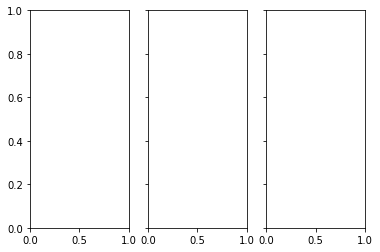

In [16]:
import os 
import glob
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import mnist
from torch.autograd import Variable
from torch import Tensor
import cv2
import torch.nn.functional as F
from loadImDat import loadData
from UTILS.class_dict import dictionary
import torchvision
from keras.datasets import mnist
from loadImDat import scaleTo01
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


class AE(nn.Module):
    #this class will create an autoencoding object
    #the objective is to simply create the autoencoder object
    #and then pass in training data to train the model
    #to very simply create the autoencoder
    def __init__(self, **kwargs):
        super().__init__()
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/modelFashion.pt"
        self.encoder=nn.Sequential(torch.load(model_dir)
        )
        self.encoder.eval()
        # self.encoder2=nn.Sequential(
            # nn.Linear(in_features=784,out_features=484)
            # )
        # self.encoder2.eval()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=784),
            nn.ReLU(),
            nn.Linear(in_features=784, out_features=784),
            nn.ReLU(),
            nn.Linear(in_features=784, out_features=784),
            nn.ReLU(),
            nn.Linear(in_features=784, out_features=784),
            nn.Sigmoid()
        )
    def trainAE(self,epochs,train_data,save=False,decoderName=1,writeTb=True,noise_factor=.5):
        """
        this is a method that will train the autoencoder.
        After this runs, it will update the constructed AE (auto encoder)
        to be a trained model.
        """
        for epoch in range(epochs):
            running_loss = 0.0
            for img,_ in train_data:
                # img, _ = data # we do not need the image labels
                # add noise to the image data
                img_noisy = img + noise_factor * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0., 1.)
                img_noisy = img_noisy.to("cuda:0")
                optimizer.zero_grad()
                outputs = model(img_noisy)
                loss = criterion(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
            
            train_loss = running_loss / len(train_data)
            print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        return train_loss 
    def forward(self, features):
        """
        this method is the logic for the forward prop. of the model.
        """
        x=self.encoder(features)
        # x=self.encoder2(x)
        x=self.decoder(x)
        return x
    def getEncoderImage(self,x):
        """
        this method will pass an image through the encoder
        and returns that image. This is mostly just for
        adding the image to the tensorboard display.
        """
        encoded_image=self.encoder(x)
        # encoded_image=self.encoder2(encoded_image)
        return encoded_image
    def saveModel(self,modelName=1):
        """
        this method will contain the code for saving the decoder model
        """
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt"
        torch.save(self.decoder,model_dir)
        print(f"model saved to {model_dir}")




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tb=SummaryWriter()
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


trainload,testload=loadData("fashion_mnist",28,10)
images,labels=next(iter(trainload))
grid=torchvision.utils.make_grid(images)
images=images.to('cuda:0')
tb.add_graph(model,images)
model.trainAE(epochs=13,train_data=trainload,save=True)
train_data=[]
for batch_idx, (true_sigs, im_labels) in enumerate(testload):
    train_data.append(true_sigs)

im_test=train_data[5][0]
im_test2=im_test.reshape(28,28)
im_test2=im_test.to('cuda:0')
pred=model(im_test2)
pred1=pred.cpu().data.numpy()
pred1=pred1.reshape(28,28)
pred=pred.cpu().reshape(28,28)
img_grid=torchvision.utils.make_grid(pred)
tb.add_image("Prediction",img_grid)

fig,axs=plt.subplots(1,3,sharey='row')
im_test2=im_test2.reshape(28,28)
im_test=im_test.to('cuda:0')
encoded_img=model.getEncoderImage(x=im_test)
encoded_img_tb=encoded_img.cpu().reshape(28,28)
img_grid=torchvision.utils.make_grid(encoded_img_tb)
tb.add_image("Encoded",img_grid)
encoded_img=encoded_img.cpu().data.numpy()
encoded_img=encoded_img.reshape(28,28)
im_test2=im_test2.cpu()
im_test3=im_test2.reshape(28,28)
img_grid=torchvision.utils.make_grid(im_test3)
tb.add_image("Original",img_grid)
tb.close()

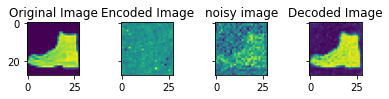

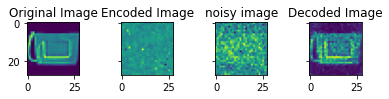

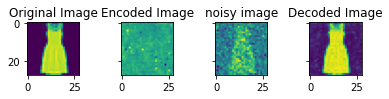

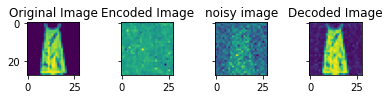

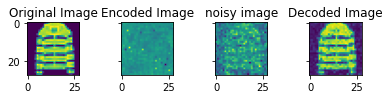

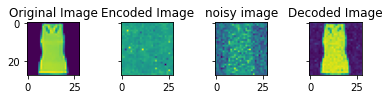

In [17]:
def plot_images(original_image,model):
    fig,axs=plt.subplots(1,4,sharey='row')
    original_image=original_image.to("cuda:0")
    axs[0].set_title("Original Image")
    axs[0].imshow(original_image.cpu().reshape(28,28))
    encoded_img=model.getEncoderImage(original_image)
    encoded_img=encoded_img.cpu().reshape(28,28)
    axs[1].set_title("Encoded Image")

    axs[1].imshow(encoded_img.detach().numpy())
    img_noise=original_image.cpu()+.5*torch.randn(original_image.cpu().shape)
    #^ that is gaussian noise
    #torch.poisson(original_image.cpu().shape)
    img_noise=img_noise.reshape(28,28)
    axs[2].set_title("noisy image")
    axs[2].imshow(img_noise)
    axs[3].set_title("Decoded Image")
    pred_img=model(original_image)
    pred_img=pred_img.cpu().reshape(28,28)
    axs[3].imshow(pred_img.detach().numpy())
    plt.subplots_adjust(wspace=.8)
    plt.show()

plot_images(train_data[802][0],model=model)
plot_images(train_data[22][0],model=model)
plot_images(train_data[33][0],model=model)
plot_images(train_data[45][0],model=model)
plot_images(train_data[51][0],model=model)
plot_images(train_data[805][0],model=model)

This is image denoising AND compression

epoch : 1/15, loss = 0.098160
epoch : 2/15, loss = 0.090754
epoch : 3/15, loss = 0.083454
epoch : 4/15, loss = 0.079113
epoch : 5/15, loss = 0.079102
epoch : 6/15, loss = 0.074498
epoch : 7/15, loss = 0.072924
epoch : 8/15, loss = 0.071845
epoch : 9/15, loss = 0.068320
epoch : 10/15, loss = 0.070132
epoch : 11/15, loss = 0.068401
epoch : 12/15, loss = 0.065798
epoch : 13/15, loss = 0.067127
epoch : 14/15, loss = 0.066011
epoch : 15/15, loss = 0.064121


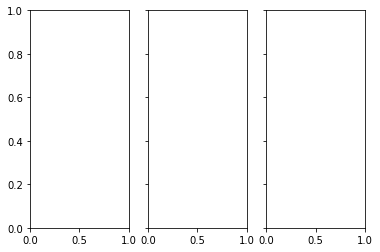

In [13]:
# %matplotlib inline
import os 
import glob
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import mnist
from torch.autograd import Variable
from torch import Tensor
import cv2
import torch.nn.functional as F
from loadImDat import loadData
from UTILS.class_dict import dictionary
import torchvision
from keras.datasets import mnist
from loadImDat import scaleTo01
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


class AE(nn.Module):
    #this class will create an autoencoding object
    #the objective is to simply create the autoencoder object
    #and then pass in training data to train the model
    #to very simply create the autoencoder
    def __init__(self, **kwargs):
        super().__init__()
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/modelFashion.pt"
        self.encoder=nn.Sequential(torch.load(model_dir)
        )
        self.encoder.eval()
        self.encoder2=nn.Sequential(
            nn.Linear(in_features=784,out_features=484),
            nn.ReLU()
            )
        self.encoder2.eval()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=484, out_features=550),
            nn.ReLU(),
            nn.Linear(in_features=550, out_features=650),
            nn.ReLU(),
            nn.Linear(in_features=650, out_features=725),
            nn.ReLU(),
            nn.Linear(in_features=725, out_features=784),
            nn.Sigmoid()
        )
    def trainAE(self,epochs,train_data,save=False,decoderName=1,writeTb=True,noise_factor=.5):
        """
        this is a method that will train the autoencoder.
        After this runs, it will update the constructed AE (auto encoder)
        to be a trained model.
        """
        for epoch in range(epochs):
            running_loss = 0.0
            for img,_ in train_data:
                # img, _ = data # we do not need the image labels
                # add noise to the image data
                img_noisy = img + noise_factor * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0., 1.)
                img_noisy = img_noisy.to("cuda:0")
                optimizer.zero_grad()
                outputs = model(img_noisy)
                loss = criterion(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
            
            train_loss = running_loss / len(train_data)
            print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        return train_loss             

    def forward(self, features):
        """
        this method is the logic for the forward prop. of the model.
        """
        x=self.encoder(features)
        x=self.encoder2(x)
        x=self.decoder(x)
        return x
    def getEncoderImage(self,x):
        """
        this method will pass an image through the encoder
        and returns that image. This is mostly just for
        adding the image to the tensorboard display.
        """
        encoded_image=self.encoder(x)
        encoded_image=self.encoder2(encoded_image)
        return encoded_image
    def saveModel(self,modelName=1):
        """
        this method will contain the code for saving the decoder model
        """
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt"
        torch.save(self.decoder,model_dir)
        print(f"model saved to {model_dir}")




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tb=SummaryWriter()
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


trainload,testload=loadData("fashion_mnist",28,10)
images,labels=next(iter(trainload))
grid=torchvision.utils.make_grid(images)
images=images.to('cuda:0')
tb.add_graph(model,images)
model.trainAE(epochs=15,train_data=trainload,save=True)
train_data=[]
for batch_idx, (true_sigs, im_labels) in enumerate(testload):
    train_data.append(true_sigs)

im_test=train_data[5][0]
im_test2=im_test.reshape(28,28)
im_test2=im_test.to('cuda:0')
pred=model(im_test2)
pred1=pred.cpu().data.numpy()
pred1=pred1.reshape(28,28)
pred=pred.cpu().reshape(28,28)
img_grid=torchvision.utils.make_grid(pred)
tb.add_image("Prediction",img_grid)

fig,axs=plt.subplots(1,3,sharey='row')
im_test2=im_test2.reshape(28,28)
im_test=im_test.to('cuda:0')
encoded_img=model.getEncoderImage(x=im_test)
encoded_img_tb=encoded_img.cpu().reshape(22,22)
img_grid=torchvision.utils.make_grid(encoded_img_tb)
tb.add_image("Encoded",img_grid)
encoded_img=encoded_img.cpu().data.numpy()
encoded_img=encoded_img.reshape(22,22)
im_test2=im_test2.cpu()
im_test3=im_test2.reshape(28,28)
img_grid=torchvision.utils.make_grid(im_test3)
tb.add_image("Original",img_grid)
tb.close()


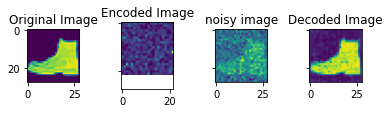

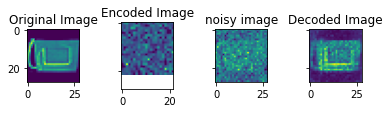

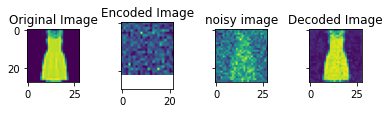

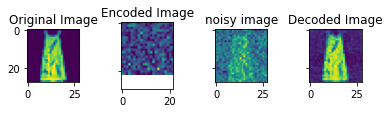

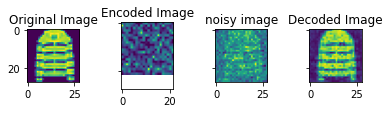

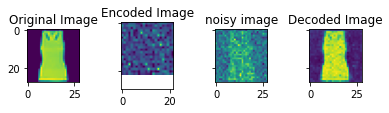

In [14]:
def plot_images(original_image,model):
    fig,axs=plt.subplots(1,4,sharey='row')
    original_image=original_image.to("cuda:0")
    axs[0].set_title("Original Image")
    axs[0].imshow(original_image.cpu().reshape(28,28))
    encoded_img=model.getEncoderImage(original_image)
    encoded_img=encoded_img.cpu().reshape(22,22)
    axs[1].set_title("Encoded Image")

    axs[1].imshow(encoded_img.detach().numpy())
    img_noise=original_image.cpu()+.5*torch.randn(original_image.cpu().shape)
    img_noise=img_noise.reshape(28,28)
    axs[2].set_title("noisy image")
    axs[2].imshow(img_noise)
    axs[3].set_title("Decoded Image")
    pred_img=model(original_image)
    pred_img=pred_img.cpu().reshape(28,28)
    axs[3].imshow(pred_img.detach().numpy())
    plt.subplots_adjust(wspace=.8)
    plt.show()

plot_images(train_data[802][0],model=model)
plot_images(train_data[22][0],model=model)
plot_images(train_data[33][0],model=model)
plot_images(train_data[45][0],model=model)
plot_images(train_data[51][0],model=model)
plot_images(train_data[805][0],model=model)

In [ ]:
#TODO: make the MRI data images smaller than 150x150

In [1]:
import os 
import glob
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import mnist
from torch.autograd import Variable
from torch import Tensor
import cv2
import torch.nn.functional as F
# from loadDataMRI import loadData
from UTILS.class_dict import dictionary
import torchvision
from keras.datasets import mnist
from loadImDat import scaleTo01
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from buildEncodingDataMRI import get_trainset


class AE(nn.Module):
    #this class will create an autoencoding object
    #the objective is to simply create the autoencoder object
    #and then pass in training data to train the model
    #to very simply create the autoencoder
    def __init__(self, **kwargs):
        super().__init__()
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/mriModel1.pt"
        self.encoder=nn.Sequential(torch.load(model_dir)
        )
        self.encoder.eval()
        # self.encoder2=nn.Sequential(
        #     nn.Linear(in_features=22500,out_features=7000),
        #     nn.ReLU(),
        #     # nn.Linear(in_features=7000,out_features=4000),
        #     # nn.ReLU(),
        #     # nn.Linear(in_features=4000,out_features=2000),
        #     # nn.ReLU(),
        #     # nn.Linear(in_features=2000,out_features=1900),
        #     # nn.ReLU(),
        #     # nn.Linear(in_features=1900,out_features=1500),
        #     # nn.ReLU(),
        #     # nn.Linear(in_features=1500,out_features=900),
        #     # nn.ReLU(),
        #     nn.Linear(in_features=7000,out_features=2025),
        #     nn.ReLU()
        #     )
        # self.encoder2.eval()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=22500, out_features=22500),
            # nn.ReLU(),
            # nn.Linear(in_features=22500, out_features=22500),
            # nn.ReLU(),
            # nn.Dropout(.25),
            # nn.Linear(in_features=1500,out_features=1900),
            # nn.ReLU(),
            # nn.Dropout(.25),
            # nn.Linear(in_features=1900,out_features=2000),
            # nn.ReLU(),
            # nn.Dropout(.25),
            # nn.Linear(in_features=2000, out_features=4000),
            # nn.ReLU(),
            # nn.Dropout(.25),
            # nn.Linear(in_features=4000,out_features=7000),
            # nn.ReLU(),
            # nn.Dropout(.25),
            # nn.ReLU(),
            # nn.Linear(in_features=22500, out_features=22500),
            nn.Sigmoid()
        )
    def trainAE(self,epochs,train_data,save=False,decoderName=1,writeTb=True):
        """
        this is a method that will train the autoencoder.
        After this runs, it will update the constructed AE (auto encoder)
        to be a trained model.
        """
        for epoch in range(epochs):
            loss = 0
            for batch_features in train_data:
                batch_features = batch_features.view(-1, 22500).to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                
                train_loss = criterion(outputs, batch_features)
                
                train_loss.backward()
                
                optimizer.step()
                
                loss += train_loss.item()
            
                

            loss = loss / len(train_data)
            if writeTb:
                tb.add_scalar("Loss",loss,epoch)
                tb.close()
            
            print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        if save:
            self.saveModel(modelName=decoderName)
    def forward(self, features):
        """
        this method is the logic for the forward prop. of the model.
        """
        x=self.encoder(features)
        # x=self.encoder2(x)
        x=self.decoder(x)
        return x
    def getEncoderImage(self,x):
        """
        this method will pass an image through the encoder
        and returns that image. This is mostly just for
        adding the image to the tensorboard display.
        """
        encoded_image=self.encoder(x)
        # encoded_image=self.encoder2(encoded_image)
        return encoded_image
    def saveModel(self,modelName=1):
        """
        this method will contain the code for saving the decoder model
        """
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt"
        torch.save(self.decoder,model_dir)
        print(f"model saved to {model_dir}")



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tb=SummaryWriter()
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset,tensorfied_images=get_trainset()
print("finished training data...")
testset,test_tensorfied_images=get_trainset(trainset=False)
print("finished test data...")
images=next(iter(trainset))
grid=torchvision.utils.make_grid(images)

images=images.to('cuda:0')
tb.add_graph(model,images)
print("about to train...")
model.trainAE(epochs=3,train_data=trainset,save=True)
print("finished training...")
#tensorfied_images = tensor version of image from dataloader

im_test=test_tensorfied_images[11]
print(len(tensorfied_images))
print(type(im_test))
print(im_test.shape)
# plt.imshow(im_test)
# plt.show()
# print(im_test)
# print(im_test.shape)
im_test2=torch.from_numpy(im_test).view(-1,22500).to("cuda:0")
# im_test2=im_test.to('cuda:0')
# im_test=im_test.reshape(22500)
im_test=torch.from_numpy(im_test).to("cuda:0")
im_test=im_test.view(-1, 22500)
pred=model(im_test)
# plt.imshow(pred)
# plt.show()
pred1=pred.cpu().data.numpy()
pred1=pred1.reshape(150,150)
pred=pred.cpu().reshape(150,150)
img_grid=torchvision.utils.make_grid(pred)
tb.add_image("Prediction",img_grid)

/nvme_ssd/bensCode/SparseCoding/fastmril/fastmri/data/transforms.py:425: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:578.)
  data = torch.ifft(data, 2, normalized=True)
finished training data...
finished test data...
about to train...
epoch : 1/3, loss = 0.021111
epoch : 2/3, loss = 0.011148
epoch : 3/3, loss = 0.009486
model saved to /nvme_ssd/bensCode/SparseCoding/models/Decoder_1.pt
finished training...
973
<class 'numpy.ndarray'>
(150, 150)


shape of og_img:torch.Size([1, 22500])
shape of encoded_img:(150, 150)
shape of decoded_img:(150, 150)


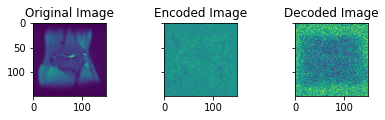

In [2]:
fig,axs=plt.subplots(1,3,sharey='row')
# im_test2=im_test2.reshape(150,150)
# im_test=im_test.to('cuda:0')
encoded_img=model.getEncoderImage(x=im_test)
encoded_img_tb=encoded_img.cpu().reshape(150,150)
img_grid=torchvision.utils.make_grid(encoded_img_tb)
tb.add_image("Encoded",img_grid)
encoded_img=encoded_img.cpu().data.numpy()
encoded_img=encoded_img.reshape(150,150)
im_test2=im_test2.cpu()
im_test3=im_test2.reshape(150,150)
img_grid=torchvision.utils.make_grid(im_test3)
tb.add_image("Original",img_grid)
tb.close()
axs[0].set_title("Original Image")
axs[0].imshow(im_test2.reshape(150,150))
print(f"shape of og_img:{im_test2.shape}")
axs[1].set_title("Encoded Image")
axs[1].imshow(encoded_img)
print(f"shape of encoded_img:{encoded_img.shape}")
axs[2].set_title("Decoded Image")
axs[2].imshow(pred1)
print(f"shape of decoded_img:{pred1.shape}")
plt.subplots_adjust(wspace=.8)
# saveImages(im_test2,encoded_img,pred1,"/nvme_ssd/bensCode/SparseCoding/outputImagesMRI/")
# plt.savefig("finalOutputs.png")
plt.show()

In [9]:
def plot_images(original_image,model):
    fig,axs=plt.subplots(1,4,sharey='row')
    # original_image=original_image.to("cuda:0")
    axs[0].set_title("Original Image")
    axs[0].imshow(original_image.reshape(150,150))
    encoded_img=model.getEncoderImage(original_image)
    encoded_img=encoded_img.cpu().reshape(150,150)
    axs[1].set_title("Encoded Image")

    axs[1].imshow(encoded_img.detach().numpy())
    img_noise=original_image.cpu()+.5*torch.randn(original_image.cpu().shape)
    img_noise=img_noise.reshape(150,150)
    axs[2].set_title("noisy image")
    axs[2].imshow(img_noise)
    axs[3].set_title("Decoded Image")
    pred_img=model(original_image)
    pred_img=pred_img.cpu().reshape(150,150)
    axs[3].imshow(pred_img.detach().numpy())
    plt.subplots_adjust(wspace=.8)
    plt.show()

plot_images(tensorfied_images[27],model=model)
plot_images(tensorfied_images[22],model=model)
plot_images(tensorfied_images[33],model=model)
plot_images(tensorfied_images[45],model=model)
plot_images(tensorfied_images[51],model=model)
plot_images(tensorfied_images[25],model=model)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'